In [1256]:
import cookielib
import urllib2
import urllib
import time
import os
import pandas as pd
import unicodedata as ud
from bs4 import BeautifulSoup
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
#import html5lib
#import opencv
import cPickle as pickle
from scipy import misc
import sys
import PIL
import numpy as np
import uuid
import random
import shutil

%matplotlib inline

In [603]:
opener = urllib2.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]

In [293]:
def scrape_K():
    #get total number of results
    item_urls = set()
    for body_type in ['Sedan','Coupe','Convertible','Cabriolet']:
        Search_main = 'http://www.koons.com/used-inventory/index.htm?bodyStyle=' + \
            body_type + '&&&&compositeType=used&'
        try:
            main_results = opener.open(Search_main)
            main_soup = BeautifulSoup(main_results)
            num_results = int(main_soup.find("div", attrs={"class":"selections"}).find("strong").text.split()[0])
            for offset in range(0, num_results, 25):
                try:
                    itemSearch = Search_main = 'http://www.koons.com/used-inventory/index.htm?start=' +  str(offset) + \
                    '&compositeType=used&bodyStyle=' + body_type + '&'       
                    item_results = opener.open(itemSearch)
                    item_soup = BeautifulSoup(item_results)
                    item_urls_all = [c.a['href'] for c in item_soup.findAll("h1", attrs={"class":"fn  h3"})]
                    item_locs_all = [c.find("dt",text=re.compile("Loc")).next_sibling.next_sibling.text for c in \
                        item_soup.findAll("dl", attrs={"class":"last"})]
                    good = [loc in ["Koons Westminster Toyota",u"Koons Annapolis Toyota","Koons Annapolis Scion","Koons Tysons Toyota",\
                        "Koons Arlington Toyota - Used Car Lot","Koons Silver Spring Ford/LINCOLN/Mazda","Mercedes-Benz of Catonsville"] for \
                        loc in item_locs_all]
                    item_urls.update([url for (url,good) in zip(item_urls_all, good) if good])
                    time.sleep(10) # don't pound the servers
                except:
                    print 'inside results page not available'
        except:
            print 'K webpage unavailable'
    return item_urls

In [602]:
def scrape_Al():
    Search_main = 'http://www.alserravw.com/preowned-cars-colorado-springs-co'
    item_urls = set() 
    try:
        main_results = urllib2.urlopen(Search_main)
        main_soup = BeautifulSoup(main_results)
        num_results = int(main_soup.find("span", attrs={"class":"total-found"}).text)   
        for page in range(1, int(math.ceil(num_results/20.))+1):
            itemSearch = 'http://www.alserravw.com/preowned-cars-colorado-springs-co?page=' + str(page)      
            item_results = urllib2.urlopen(itemSearch)
            item_soup = BeautifulSoup(item_results)
            item_urls.update([c["content"] for c in item_soup.findAll("meta", attrs={"itemprop": "url"})])
            time.sleep(5) # don't pound the servers
    except:
        print 'Al webpage unavailable'
    return item_urls

In [361]:
def scrape_Al_mi():
    Search_main = 'http://www.alserra.com/search/used/tp/s:tm1/?bd=1688-2d_convertible&bd=1683-2d_coupe&bd=1673-2d_hatchback&bd=1697-4d_coupe&bd=1680-4d_hatchback&bd=1674-4d_sedan&bd=1685-4d_wagon&bd=1677-5d_hatchback'
    item_urls = set() 
    try:
        main_results = opener.open(Search_main)
        main_soup = BeautifulSoup(main_results)
        num_results = int(main_soup.find("div", attrs = {"class":"srp_results_count_container"}).text.split(' ')[0])
        print 'there are ' + str(num_results) + ' results'
        sys.stdout.flush()   
        for page in range(1, int(math.ceil(num_results/100.))+1):
            print 'grabbing page ' + str(page)
            sys.stdout.flush()
            try:
                itemSearch = 'http://www.alserra.com/search/used-2d_convertible,2d_coupe,2d_hatchback,4d_coupe,4d_hatchback,4d_sedan,4d_wagon,5d_hatchback/tp-bd1688,1683,1673,1697,1680,1674,1685,1677/s:tm1,c:100,p:' + str(page) + '/'     
                item_results = opener.open(itemSearch)
                item_soup = BeautifulSoup(item_results)
                item_urls.update([c.a['href'] for c in item_soup.findAll("div", attrs = {"class": "srp_vehicle_title_container"})])
            except:
                print 'internal AL mi webpage refused'
                sys.stdout.flush()
            time.sleep(5) # don't pound the servers
    except:
        print 'Al MI webpage unavailable'
        sys.stdout.flush()
    return item_urls

In [604]:
def scrape_RC():
    Search_main = 'http://rickcase.com/Pre-Owned_Inventory#bodyStyle:Convertible%252CCoupe%252CHatchback%252CSedan'
    item_urls = set()
    try:
        main_results = urllib2.urlopen(Search_main)
        main_soup = BeautifulSoup(main_results)
        num_results = int(main_soup.find("p", attrs={"class":"matchTitle"}).text.split(' ')[0])
        for page in range(0, num_results, 50):
            itemSearch = 'http://rickcase.com/Pre-Owned_Inventory/bodyStyle/Convertible%252CCoupe%252CHatchback%252CSedan/rowsToReturn/50/startRow/' + str(page)
            item_results = urllib2.urlopen(itemSearch)
            item_soup = BeautifulSoup(item_results)
            item_urls.update([c['href'] for c in item_soup.find("div", attrs={"class":"vehicles exactMatch"}).findAll("a", attrs={"itemprop":"url"})])
        time.sleep(5)
    except:
        print 'RC webpage unavailable'
    return item_urls

In [685]:
def parse_K_pages(car_urls):
    carPics = {}
    for car in car_urls:
        carURL = r"http://www.koons.com" + car
        try: 
            carpage = opener.open(carURL)
            soup = BeautifulSoup(carpage)
            dealer = soup.find("span", attrs={"class":"org"}).text
            if dealer == u"Koons Westminster Toyota":
                if len(soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")) >=9:
                    car_photos = [c['href'] for c in soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")]
                    carPics[car_photos[1]] = 'front-right-corner'
                    carPics[car_photos[2]] = 'front'
                    carPics[car_photos[3]] = 'front-left-corner'
                    carPics[car_photos[4]] = 'left-side'
                    carPics[car_photos[5]] = 'rear-left-corner'
                    carPics[car_photos[6]] = 'rear'
                    carPics[car_photos[7]] = 'rear-right-corner'
                    carPics[car_photos[8]] = 'right-side'
            elif dealer in ["Koons Tysons Toyota"]:
                if len(soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")) >=7:
                    car_photos = [c['href'] for c in soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")]
                    carPics[car_photos[1]] = 'front-right-corner'
                    carPics[car_photos[2]] = 'front'
                    carPics[car_photos[3]] = 'front-left-corner'
                    carPics[car_photos[5]] = 'rear'
            elif dealer in ["Koons Arlington Toyota - Used Car Lot"]:
                if len(soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")) >=8:
                    car_photos = [c['href'] for c in soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")]
                    carPics[car_photos[1]] = 'right-side'
                    carPics[car_photos[2]] = 'rear-right-corner'
                    carPics[car_photos[3]] = 'rear'
                    carPics[car_photos[4]] = 'rear-left-corner'
                    carPics[car_photos[5]] = 'left-side'
                    carPics[car_photos[6]] = 'front-left-corner'
                    carPics[car_photos[7]] = 'front'
            elif dealer in ["Koons Silver Spring Ford/LINCOLN/Mazda"]:
                if len(soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")) >=5:
                    car_photos = [c['href'] for c in soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")]
                    carPics[car_photos[1]] = 'front'
                    carPics[car_photos[2]] = 'front-right-corner'
                    carPics[car_photos[3]] = 'rear-left-corner'
                    carPics[car_photos[4]] = 'rear-right-corner'  
            elif dealer in [u"Koons Falls Church Ford"]:
                if len(soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")) >=6:
                    car_photos = [c['href'] for c in soup.find("ul", attrs= {"class":" jcarousel"}).findAll("a")]
                    carPics[car_photos[1]] = 'front'
                    carPics[car_photos[2]] = 'front-left-corner'
                    carPics[car_photos[3]] = 'rear-right-corner'
                    carPics[car_photos[4]] = 'rear'
                    carPics[car_photos[5]] = 'rear-left-corner'
        except:
            print "error on " + carURL
        time.sleep(5)
    return(carPics)

In [7]:
def parse_Al_pages(car_urls):
    carPics = {}
    car_types = re.compile("Sedan|Coupe|Hatchback|Convertible|Wagon")
    for carURL in car_urls:
        try: 
            carpage = urllib2.urlopen(carURL)
            soup = BeautifulSoup(carpage)
            body = soup.find("ul", attrs= {"class":"specification col-sm-6"}).findAll("span", attrs={"class":"value"})[3].text
            if car_types.search(body):
                if int(soup.find("span", attrs = {"class":"media-count"}).text.split("/")[1]) > 5:
                    car_photos = [i.img['src'] for i in soup.find("div", attrs={"class":"images"}).ul.findAll("li")]
                    carPics[car_photos[1]] = 'right-side'
                    carPics[car_photos[2]] = 'rear-right-corner'
                    carPics[car_photos[3]] = 'rear'
                    carPics[car_photos[4]] = 'rear-left-corner'
                    carPics[car_photos[5]] = 'left-side'
                    carPics[car_photos[6]] = 'front-left-corner'
                    carPics[car_photos[7]] = 'front'
                elif int(soup.find("span", attrs = {"class":"media-count"}).text.split("/")[1]) == 5:
                    carPics[car_photos[1]] = 'front-left-corner'
                    carPics[car_photos[2]] = 'rear-left-corner'
                    carPics[car_photos[3]] = 'rear-right-corner'
        except:
            print "error on " + carURL
        time.sleep(2)
    return(carPics)

In [594]:
def parse_Al_mi_pages(car_urls):
    carPics = {}
    car_urls
    for car in car_urls:
        carURL = 'http://www.alserra.com' + car
        try:
            carpage = opener.open(carURL)
            soup=BeautifulSoup(carpage)
            car_photos = [c['content'] for c in soup.findAll("meta", attrs ={"property":"og:image"})]
            if len(car_photos) > 7:
                if not re.search(re.compile('[_]o.jpg'),car_photos[0]):
                    if re.search(re.compile('Honda of Grand Blanc'),soup.find("label", attrs={"class":"bold vdp_directions_label"}).text):
                        carPics[car_photos[0]] = 'front-right-corner-BORDERED'
                        carPics[car_photos[1]] = 'front-BORDERED'
                        carPics[car_photos[2]] = 'front-left-corner-BORDERED'
                        carPics[car_photos[3]] = 'left-side-BORDERED'
                        carPics[car_photos[4]] = 'rear-left-corner-BORDERED'
                        carPics[car_photos[5]] = 'rear-BORDERED'
                        carPics[car_photos[6]] = 'rear-right-corner-BORDERED'
                        carPics[car_photos[7]] = 'right-side-BORDERED'
                    else:
                        carPics[car_photos[0]] = 'front-right-corner'
                        carPics[car_photos[1]] = 'front'
                        carPics[car_photos[2]] = 'front-left-corner'
                        carPics[car_photos[3]] = 'left-side'
                        carPics[car_photos[4]] = 'rear-left-corner'
                        carPics[car_photos[5]] = 'rear'
                        carPics[car_photos[6]] = 'rear-right-corner'
                        carPics[car_photos[7]] = 'right-side'
        except:
            print "error on " + carURL
        sys.stdout.write("-")
        sys.stdout.flush()
        time.sleep(2)
    return(carPics)

In [509]:
def parse_RC_pages(car_urls):
    carPics = {}
    for carURL in car_urls:
        try: 
            carpage = urllib2.urlopen('http://rickcase.com' + carURL)
            soup = BeautifulSoup(carpage)
            car_photos = [li.split("\'") for li in re.findall(re.compile('.*vehicle_photos.*.jpg'),soup.get_text())]
            car_photos = [li[1] if len(li)>1 else li[0] for li in car_photos]
            loc = soup.get_text().split("body")[0]
            if len(car_photos) > 4:
                if re.search(re.compile("Cleveland"),loc):
                    carPics[car_photos[1]] = 'front-left-corner-FRAMED'
                    carPics[car_photos[2]] = 'left-side-FRAMED'
                    carPics[car_photos[3]] = 'rear-left-corner-FRAMED'
                    carPics[car_photos[4]] = 'rear-FRAMED'
                    carPics[car_photos[5]] = 'rear-right-corner-FRAMED'
                    carPics[car_photos[6]] = 'right-side-FRAMED'
                    carPics[car_photos[7]] = 'front-right-corner-FRAMED'
                    carPics[car_photos[8]] = 'front-FRAMED'
                elif re.search(re.compile('Kia Florida|Rick Case Hyundai Davie'),loc):
                    carPics[car_photos[3]] = 'front'
                    carPics[car_photos[4]] = 'front-left-corner'
                elif re.search(re.compile("Mazda Duluth|Rick Case Kia|Hyundai Duluth"),loc):
                    carPics[car_photos[1]] = 'front-left-corner'
                    carPics[car_photos[2]] = 'left-side'
                    carPics[car_photos[3]] = 'rear-left-corner'
                    carPics[car_photos[4]] = 'rear'
                    carPics[car_photos[5]] = 'rear-right-corner'
                    carPics[car_photos[6]] = 'right-side'
                    carPics[car_photos[7]] = 'front-right-corner'
                    carPics[car_photos[8]] = 'front'
                elif re.search(re.compile("Hyundai Ft. Lauderdale"),loc):        
                    carPics[car_photos[2]] = 'left-side'  
                elif re.search(re.compile('Rick Case Acura'),loc):
                    carPics[car_photos[0]] = 'front-left-corner'
                    carPics[car_photos[2]] = 'left-side'
                elif re.search(re.compile("Rick Case VW"),loc):
                    carPics[car_photos[2]] = 'front-left-corner'
                    carPics[car_photos[3]] = 'front'
                    carPics[car_photos[4]] = 'front-right-corner'
                    carPics[car_photos[6]] = 'right-side'
                    carPics[car_photos[8]] = 'rear-right-corner'
                    carPics[car_photos[9]] = 'rear'
                    carPics[car_photos[10]] = 'rear-left-corner'
                    carPics[car_photos[12]] = 'left-side'
                else:
                    print "Unusable Dealership"
            else:
                print "Too few photos"
        except:
            print "error on " + carURL
        time.sleep(2)
    return(carPics)

In [927]:
def get_images(img_list):
    for img in img_list:
        image_name = img.replace('/','|')
        if not re.search(re.compile('.jpg'),image_name):
            image_name = image_name + '.jpg'
        if not os.path.isfile('Car_images/' + image_name):
            if re.search(re.compile('http'),img):
                urllib.urlretrieve(img,'Car_images/' + image_name)
            else:
                urllib.urlretrieve('http:' + img,'Car_images/' + image_name)
        else:
            try:
                img_read = misc.imread('Car_images/' + image_name) 
                if img_read.shape[0] < 200:
                    if re.search(re.compile('http'),img):
                        urllib.urlretrieve(img,'Car_images/' + image_name)
                    else:
                        urllib.urlretrieve('http:' + img,'Car_images/' + image_name)
            except:
                print "image load error for " + img

In [570]:
def update_carSet():
    #scrape new 
    print 'scraping'
    sys.stdout.flush()
    newSet_K = scrape_K()
    newSet_Al = scrape_Al()
    newSet_RC = scrape_RC()
    newSet_Al_mi = scrape_Al_mi()
    #label everything
    print 'labeling'
    sys.stdout.flush()
    new_labeled_K = parse_K_pages(newSet_K)
    new_labeled_Al = parse_Al_pages(newSet_Al)
    new_labeled_RC = parse_RC_pages(newSet_RC)   
    new_labeled_Al_mi = parse_Al_mi_pages(newSet_Al_mi)
    #merge labels
    print 'merging new labels'
    sys.stdout.flush()
    new_labeled = new_labeled_K.copy()
    new_labeled.update(new_labeled_Al)
    new_labeled.update(new_labeled_RC)
    new_labeled.update(new_labeled_Al_mi)
    #merge with old dictionary
    print 'merging with old dictionary'
    sys.stdout.flush()
    global car_labeled
    car_labeled.update(new_labeled)
    #get any photos not on file
    print 'downloading images'
    sys.stdout.flush()
    get_images(car_labeled.keys())

In [898]:
def crop_framed(image):
    global car_labeled
    image_name = image.replace('/','|')
    if not re.search(re.compile('.jpg'),image_name):
        image_name = image_name + '.jpg'
    if os.path.isfile('Car_images/' + image_name):
        img = misc.imread('Car_images/' + image_name)
        img_cropped = img[110:350,20:600,:]
        misc.imsave('Car_images/' + image_name, img_cropped)
        #update label to reflect crop
        car_labeled[image] = car_labeled[image].replace('-FRAMED','')
    else:
        del car_labeled[image]

In [899]:
def crop_bordered(image):
    global car_labeled
    #string replace for the actual image names without /s
    image_name = image.replace('/','|')
    if not re.search(re.compile('.jpg'),image_name):
        image_name = image_name + '.jpg'
    if os.path.isfile('Car_images/' + image_name):
        img = misc.imread('Car_images/' + image_name)
        img_cropped = img[40:430,:,:]
        misc.imsave('Car_images/' + image_name, img_cropped)
        #update label to reflect crop
        car_labeled[image] = car_labeled[image].replace('-BORDERED','')
    else:
        del car_labeled[image]

In [664]:
def delete_art_bkg(image):
    global car_labeled
    image_name = image.replace('/','|')
    if not re.search(re.compile('.jpg'),image_name):
        image_name = image_name + '.jpg'
    if os.path.isfile('Car_images/' + image_name):
        img = misc.imread('Car_images/' + image_name)
        hist,bins = np.histogram(img,256,[0,256])
        if hist[-1]/float(len(img.ravel())) > 0.1:
            os.remove('Car_images/' + image_name)
            del car_labeled[image]
#         print 'artificial background'
#     else:
#         print 'normal background'
#     plt.imshow(img)
#     plt.show()

In [1008]:
def crop_unlabeled_frames(image):
    blue_pct = 0
    red_pct = 0
    dkblue_pct = 0
    BLUE_MIN = np.array([0,0,130], np.uint8)
    BLUE_MAX = np.array([40,90,180], np.uint8)
    RED_MIN = np.array([180,0,0], np.uint8)
    RED_MAX = np.array([200,30,50], np.uint8)
    DKBLUE_MIN = np.array([0,20,50], np.uint8)
    DKBLUE_MAX = np.array([10,40,70], np.uint8)
    if re.search(re.compile('cotillion'),image):
        image_name = image.replace('/','|')
        if not re.search(re.compile('.jpg'),image_name):
            image_name = image_name + '.jpg'
        if os.path.isfile('Car_images/' + image_name):
            try:
                img = misc.imread('Car_images/' + image_name)
                blue_count = 0
                red_count = 0
                dkblue_count = 0
                for x in range(img.shape[0]):
                    for y in range(img.shape[1]):
                        if img[x,y,0] > BLUE_MIN[0] and img[x,y,0] < BLUE_MAX[0] and\
                            img[x,y,1] > BLUE_MIN[1] and img[x,y,1] < BLUE_MAX[1] and\
                            img[x,y,2] > BLUE_MIN[2] and img[x,y,2] < BLUE_MAX[2]:
                            blue_count +=1
                        if img[x,y,0] > RED_MIN[0] and img[x,y,0] < RED_MAX[0] and\
                            img[x,y,1] > RED_MIN[1] and img[x,y,1] < RED_MAX[1] and\
                            img[x,y,2] > RED_MIN[2] and img[x,y,2] < RED_MAX[2]:
                            red_count +=1
                        if img[x,y,0] > DKBLUE_MIN[0] and img[x,y,0] < DKBLUE_MAX[0] and\
                            img[x,y,1] > DKBLUE_MIN[1] and img[x,y,1] < DKBLUE_MAX[1] and\
                            img[x,y,2] > DKBLUE_MIN[2] and img[x,y,2] < DKBLUE_MAX[2]:
                            dkblue_count +=1
                blue_pct = float(blue_count)/(img.shape[0]*img.shape[1])
                red_pct = float(red_count)/(img.shape[0]*img.shape[1])
                dkblue_pct = float(dkblue_count)/(img.shape[0]*img.shape[1])
            except:
                print 'error'
    if blue_pct > 0.15 or red_pct > 0.10 or dkblue_pct > 0.12:
        crop_framed(image)

In [1238]:
#scrape and get all the labels for the four dealership groups, merge with last held list
# car_labeled = {}
#car_labeled = pickle.load(open('car_labels.pkl','rb'))
car_labeled_old = car_labeled.copy()
update_carSet()
pickle.dump(car_labeled, open('car_labels.pkl', 'wb'))

scraping
there are 185 results
grabbing page 1
grabbing page 2
labeling
error on http://www.koons.com/used/Toyota/2015-Toyota-Camry-baltimore-washington-dc-d068a8df0a0e0adf52e53927104b9ce4.htm
error on http://www.koons.com/used/Ford/2013-Ford-Fusion-baltimore-washington-dc-f9b19e1c0a0e0a6b6dc3cd8aaa7a7c81.htm
error on http://www.koons.com/used/Dodge/2015-Dodge-Dart-baltimore-washington-dc-03e80a800a0e0a6b6dc3cd8ad3df54b0.htm
error on http://www.koons.com/used/Ford/2012-Ford-Fiesta-baltimore-washington-dc-0e4ba4a10a0e0a6b6dc3cd8ab01ffbd4.htm
error on http://www.koons.com/used/Lincoln/2014-Lincoln-MKS-baltimore-washington-dc-f46f6d590a0e0ae84c12d7156f4f2602.htm
error on http://www.koons.com/certified/Toyota/2012-Toyota-Corolla-baltimore-washington-dc-f46f75bf0a0e0adf52e53927253a665d.htm
error on http://www.koons.com/used/Mazda/2012-Mazda-Mazda6-baltimore-washington-dc-ef64f2400a0e0a1704ec476ad84d5a3c.htm
error on http://www.koons.com/used/Honda/2005-Honda-Accord-baltimore-washington-dc-0

In [1254]:
# find and crop framed images, relabel
framed = [image for (image, orient) in car_labeled.iteritems() if orient in ['front-left-corner-FRAMED',\
        'left-side-FRAMED','rear-left-corner-FRAMED', 'rear-FRAMED','rear-right-corner-FRAMED',\
        'right-side-FRAMED','front-right-corner-FRAMED','front-FRAMED']]
map(crop_framed,framed)

# #find and crop bordered images, relabel
bordered = [image for (image,orient) in car_labeled.iteritems() if orient in ['front-left-corner-BORDERED',\
        'left-side-BORDERED', 'rear-left-corner-BORDERED', 'rear-BORDERED','rear-right-corner-BORDERED',\
        'right-side-BORDERED', 'front-right-corner-BORDERED', 'front-BORDERED']]
map(crop_bordered,bordered)

# #find and remove images with white background
map(delete_art_bkg,car_labeled.keys())

# # find images that have been overcropped and redownload
# get_images(car_labeled.keys())

#find other bordered images and crop
map(crop_unlabeled_frames,car_labeled.keys())

# for (key,value) in car_labeled.iteritems():
    if value == 'rear-left-corner':
        car_labeled[key] = 'left-rear-corner'
    elif value == 'rear-right-corner':
        car_labeled[key] = 'right-rear-corner'
    elif value == 'front-right-corner':
        car_labeled[key] = 'right-front-corner'
    elif value == 'front-left-corner':
        car_labeled[key] = 'left-front-corner'

# set(car_labeled.values())

#move everything into separate folders to easily check labelling
for (image,orient) in car_labeled.iteritems():
    image_name = image.replace('/','|')
    if not re.search(re.compile('.jpg'),image_name):
        image_name = image_name + '.jpg'
    if os.path.isfile('Car_images/' + image_name):
        os.rename('Car_images/' + image_name, 'Car_images/' + orient + '/' + image_name)

**Hand clean in orientation folders for incorrect labelling and shots not of car body**

In [1259]:
#Create new dictionary with cleaned
car_labeled_cleaned = {}

#os.mkdir('Car_images/cleaned_set')

def copy_images(image_name, orient):
    global car_labeled_sep
    newguid = uuid.uuid4()
    shutil.copyfile('Car_images/' + orient + '/' + image_name, 'Car_images/cleaned_set/' + str(newguid) + '.jpg')
    car_labeled_cleaned[str(newguid)] = orient

for orient in set(car_labeled.values()):
    files = os.listdir('Car_images/' + orient)
    print orient
    [copy_images(file,orient) for file in files]


left-rear-corner
right-front-corner
right-rear-corner
left-front-corner
right-side
front
left-side
rear


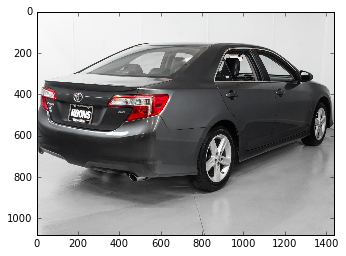

('336b6beb-f0e4-4113-b00b-c49a63946e1a', 'right-rear-corner')


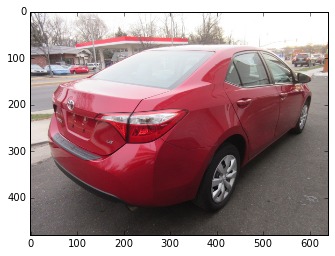

('08d8e26d-924f-4c60-bf8c-1a816351daef', 'right-rear-corner')


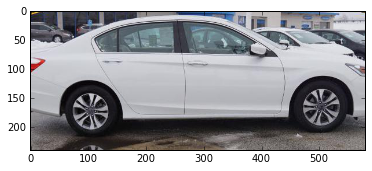

('223198f2-21b8-4cab-bc98-c258176980ac', 'right-side')


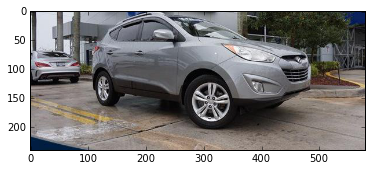

('c402e7eb-68ec-41c0-b412-4a9f22eeb70d', 'right-front-corner')


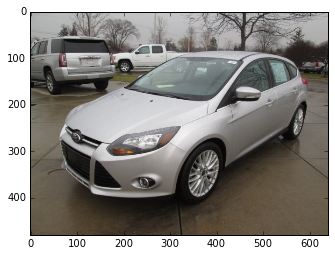

('deeccf37-a513-481c-94be-b71a3655547a', 'left-front-corner')


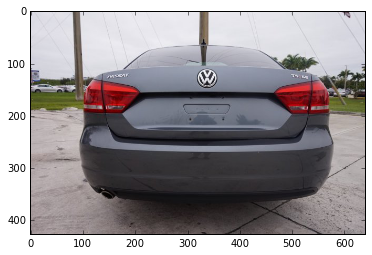

('4dd442ad-bac6-451e-b513-b1d4fcfeb32d', 'rear')


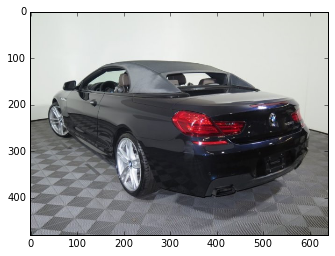

('91261ef2-3c5e-4799-be79-ff7acc5b0a80', 'left-rear-corner')


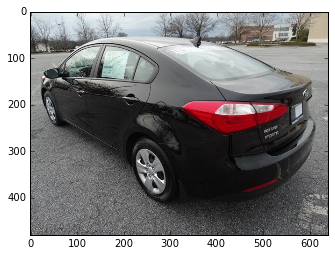

('23efbc86-2f42-44a3-b6e5-5dabe26b9f0a', 'left-rear-corner')


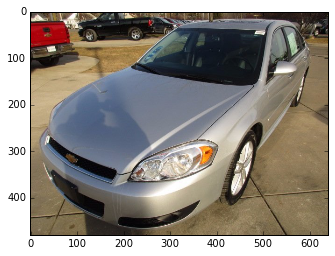

('1003943d-9435-4ab7-a132-be6fb081b71d', 'left-front-corner')


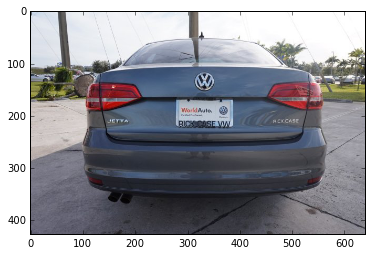

('ad38c048-41b3-4425-9d1b-ac82cb6b17f5', 'rear')


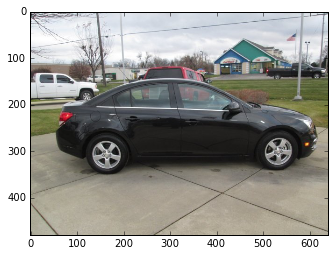

('2731f7ce-0231-4f45-aa37-c8f7aff210b0', 'right-side')


In [1263]:
#Double-check the data
count = 0
while count<11:
    pair = car_labeled_cleaned.popitem()
    img = plt.imread('Car_images/cleaned_set/' +  pair[0] + '.jpg')
    plt.imshow(img)
    plt.show()
    print pair
    count +=1

In [1264]:
#Assign numerical classes to orientations to match POI codes
orient_codes = pd.Series(range(0,13), index=['not-car-ext','right-front-corner','right-front-side','right-side','right-rear-side',\
        'right-rear-corner','rear','left-rear-corner','left-rear-side','left-side','left-front-side', \
        'left-front-corner','front'])
print orient_codes

not-car-ext            0
right-front-corner     1
right-front-side       2
right-side             3
right-rear-side        4
right-rear-corner      5
rear                   6
left-rear-corner       7
left-rear-side         8
left-side              9
left-front-side       10
left-front-corner     11
front                 12
dtype: int64


In [1122]:
#Split into validation and training sets and create series for test and validation
car_val = pd.Series()
car_train = pd.Series()

#for orient in set(car_labeled_sep.values()):
for orient in orient_codes.keys()[[1,3,5,6,7,9,11,12]]:
    files = os.listdir('Car_images/' + orient)[1:]
    val = random.sample(range(len(files)), int(len(files)*0.1))
    for num in range(len(files)):
        if num in val:
            car_val['Car_images/' + files[num]] = orient_codes[orient]
            rename('Car_images/' + orient + '/' + files[num], 'Car_images/' + files[num])
        else:
            car_train['Car_images/' + files[num]] = orient_codes[orient]
            rename('Car_images/' + orient + '/' + files[num], 'Car_images/' + files[num]

right-side
AxesImage(60,40;372x248)


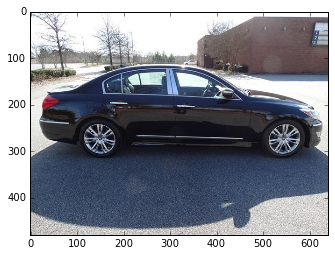

left-front-corner
AxesImage(60,40;372x248)


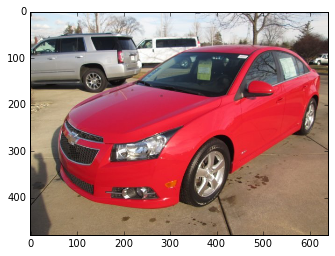

right-rear-corner
AxesImage(60,40;372x248)


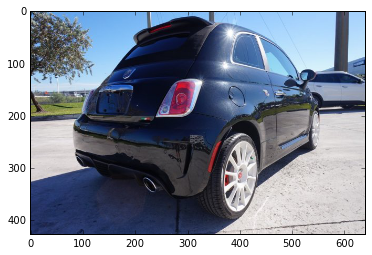

left-rear-corner
AxesImage(60,40;372x248)


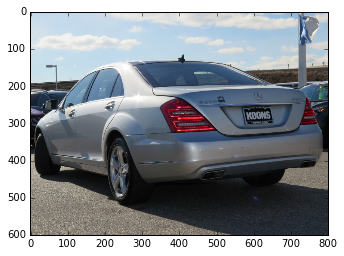

left-front-corner
AxesImage(60,40;372x248)


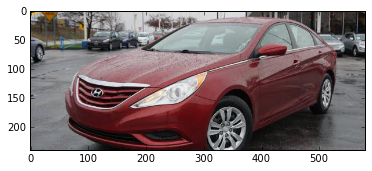

right-front-corner
AxesImage(60,40;372x248)


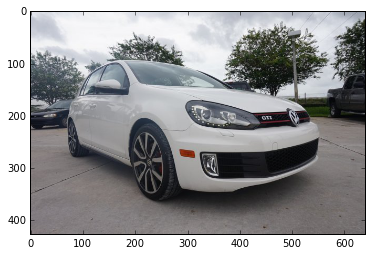

left-rear-corner
AxesImage(60,40;372x248)


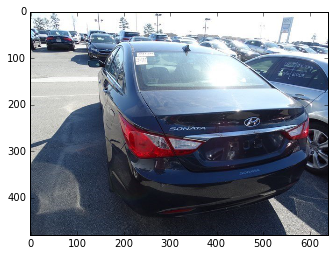

right-rear-corner
AxesImage(60,40;372x248)


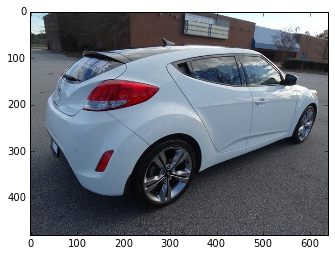

left-rear-corner
AxesImage(60,40;372x248)


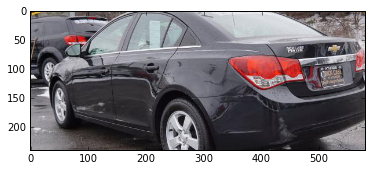

front
AxesImage(60,40;372x248)


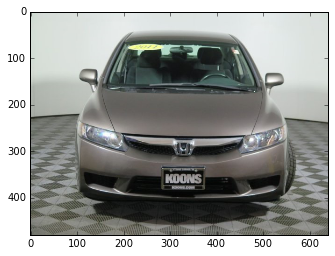

right-rear-corner
AxesImage(60,40;372x248)


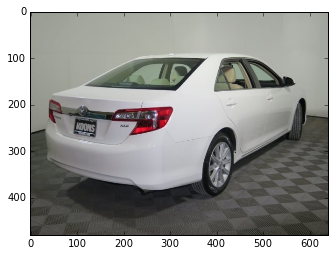

right-front-corner
AxesImage(60,40;372x248)


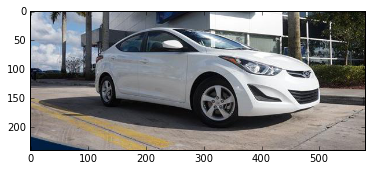

rear
AxesImage(60,40;372x248)


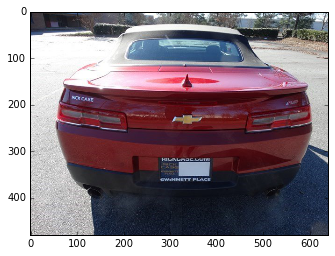

right-front-corner
AxesImage(60,40;372x248)


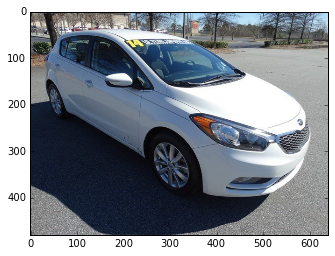

front
AxesImage(60,40;372x248)


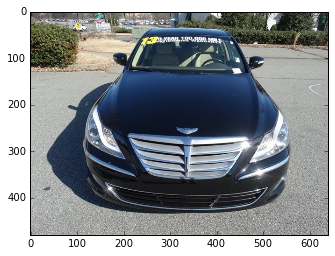

right-side
AxesImage(60,40;372x248)


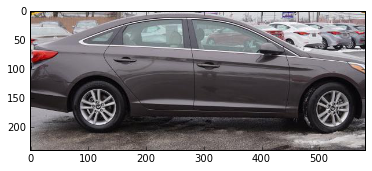

front
AxesImage(60,40;372x248)


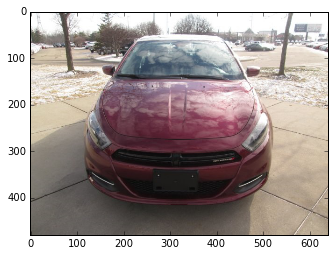

left-rear-corner
AxesImage(60,40;372x248)


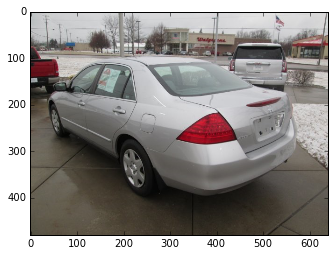

left-front-corner
AxesImage(60,40;372x248)


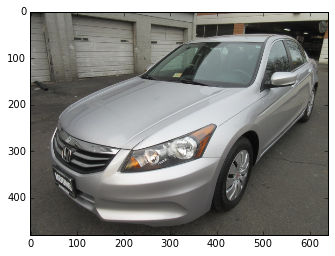

left-rear-corner
AxesImage(60,40;372x248)


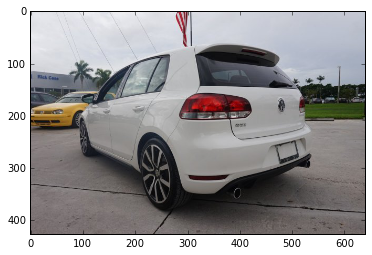

In [1131]:
#print a test
for num in random.sample(range(len(car_train)),20):
    print orient_codes.keys()[car_train[num]]
    print plt.imshow(plt.imread(car_train.keys()[num]))
    plt.show()

In [1123]:
#write validation/train sets out to txt for safety
car_val.to_csv('Validation.txt',sep=' ')
car_train.to_csv('Train.txt', sep=' ')

In [1206]:
#Cut half of rights and lefts in half
def create_side_halves(image_pair, set):
    global car_val
    global car_train
    img = misc.imread(image_pair[0])
    width = img.shape[1]
    img1 = img[:,0:width/2,:]
    img2 = img[:,width/2:,:]
    #create guids for each image and save
    guid1 = uuid.uuid4()
    guid2 = uuid.uuid4()
    misc.imsave('Car_images/' + str(guid1) + '.jpg', img1)
    misc.imsave('Car_images/' + str(guid2) + '.jpg', img2)
    if set == 'val':
        if image_pair[1] == 3:
            car_val['Car_images/' + str(guid1) + '.jpg'] = 4
            car_val['Car_images/' + str(guid2) + '.jpg'] = 2
        if image_pair[1] == 9:
            car_val['Car_images/' + str(guid1) + '.jpg'] = 10
            car_val['Car_images/' + str(guid2) + '.jpg'] = 8
    elif set == 'train':
        if image_pair[1] == 3:
            car_train['Car_images/' + str(guid1) + '.jpg'] = 4
            car_train['Car_images/' + str(guid2) + '.jpg'] = 2
        if image_pair[1] == 9:
            car_train['Car_images/' + str(guid1) + '.jpg'] = 10
            car_train['Car_images/' + str(guid2) + '.jpg'] = 8            

In [1236]:
# [create_side_halves(pair,'val') for pair in car_val[car_val.isin([3,9])].iteritems()]
# [create_side_halves(pair,'train') for pair in car_train[car_train.isin([3,9])].iteritems()]
#car_train.value_counts()
# files = set(os.listdir('Car_images'))
# files = list(files - set(car_val.index.append(car_train.index)))
# os.mkdir('Extras')
#[os.rename('Car_images/' + file, 'Extras/' + file) for file in files]
# for file in [file for (file,label) in car_train.iteritems() if label in [2,4,8,10]]:
#     try:
#         os.remove(file)
#     except:
#         print 'file missing'
#     car_train.drop(file,inplace=True)
    


file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing
file missing

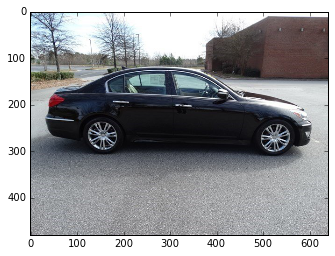

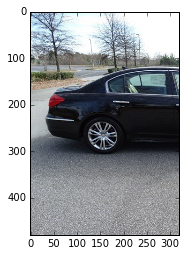

code = 4 right-rear-side


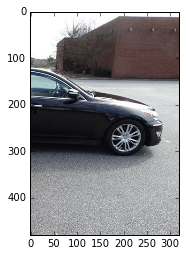

code = 2 right-front-side


In [1176]:
image_pair = (car_val[car_val.isin([3,9])].index[25],car_val[car_val.isin([3,9])][25])
img = misc.imread(image_pair[0])
width = img.shape[1]
img1 = img[:,0:width/2,:]
img2 = img[:,width/2:,:]
plt.imshow(img)
plt.show()
plt.imshow(img1)
plt.show()
if image_pair[1] == 3:
    print 'code = 4 ' + orient_codes.keys()[4]
else: 
    print 'code = 10 ' + orient_codes.keys()[10]
plt.imshow(img2)
plt.show()
if image_pair[1] == 3:
    print 'code = 2 ' + orient_codes.keys()[2]
else: 
    print 'code = 8 ' + orient_codes.keys()[8]


In [1174]:
orient_codes.keys()[4]

'right-rear-side'

In [ ]:

#resize everything and center on network image mean

#split validation set

#cut sides in half